# Import data

The import code in this section is specific to the CSV automatically generated for each collective dialouge on remesh. To use data from other sources, import code will need written which transforms the data into the following format:


*   A list named *qs* where each list entry is a dataframe with data for a quesiton/prompt
*   Each data frame for a quesiton/prompt is formatted such that rows correspond to *responses* and there are the following columns: *Question*, *Question Type*, *Responses* , *Segment 1* , *Segment 2*, ... , *Segmnet N*
*   The values in the columns for each segment are the fraction of participants in that segment which agree with the response in that row.

It is also helpful to have the code output the list of questions and segments and their IDs so they can be referenced by ID for use in later sections of this notebook.



In [1]:
from google.colab import files
import pandas as pd
import csv
import io
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import data from file
uploaded = files.upload()
filename = next(iter(uploaded))
with open(filename,'r') as file:
  csvreader = csv.reader(file)
  r = 1
  data = []
  qdata = []
  for row in csvreader:
    if r>9:
      if row == []:
        data.append(qdata)
        qdata = []
      else:
        qdata.append(row)
    r=r+1

#handle blank row
data = data[1:]

#percent string to float
def p2f(x):
  return float(x.strip('%'))/100

#make numeric
nq = len(data)
qs = []
meta = [["question type","question text"]]
for i in range(0,nq):
  d = data[i]
  m = [d[1][1],d[1][2]]
  meta.append(m)
  if d[1][1] == 'Poll Single Select':
    for r in range(1,len(d)):
      for c in range(4,len(d[0])):
        d[r][c] = p2f(d[r][c])
  if d[1][1] == 'Ask Opinion':
    for r in range(1,len(d)):
      for c in range(5,len(d[0])-3):
        d[r][c] = p2f(d[r][c])
  df = pd.DataFrame(d[1:],columns = d[0])
  qs.append(df)
qmeta = pd.DataFrame(meta[1:],columns = meta[0])

print("Questions:")
qmeta

Saving social_media_trust.csv to social_media_trust.csv
Questions:


,question type,question text
0,Poll Single Select,How old are you?
1,Poll Single Select,What is your gender?
2,Poll Single Select,About how often do you use social media?
3,Poll Single Select,If you could only choose one of the following ...
4,Poll Single Select,Which social media platform do you use MOST of...
5,Ask Opinion,If you could only keep one social media app do...
6,Ask Opinion,Think of the app you mentioned above. Pretend ...
7,Ask Opinion,"What role, if any, do social media companies p..."
8,Poll Multi Select,Which of the following roles do you think soci...
9,Ask Opinion,"What role, if any, do social media companies p..."


In [3]:
#extract segments
d=data[0]
segments = []
if d[1][1] == 'Poll Single Select':
  r=0
  for c in range(4,len(d[0])):
    segments.append(d[r][c])
if d[1][1] == 'Ask Opinion':
  r=0
  for c in range(5,len(d[0])-3):
    segments.append(d[r][c])
print("Segments")
pd.DataFrame(segments)

Segments


,0
0,All(4167)
1,Use Reddit most (616)
2,use FB most (1379)
3,Use IG most (971)
4,Use TikTok most (390)
5,Use Twitter most (672)
6,Under 30 (1358)
7,Over 30 (1494)
8,Male (2066)
9,Female (2037)


# Visualize poll data

This section enables a simple visualization of poll data cut by segments.

In [4]:
import matplotlib.pyplot as plt
plt.close("all")

In [5]:
#plot poll data
def plot_poll(df,segs):
  print(df["Question"][1])
  segs_incl = ['Responses']
  for i in range(0,len(segs)):
    segs_incl.append(df.columns[4+segs[i]])
  dfplt = df[segs_incl]
  dfplt = dfplt.set_index('Responses')
  dfplt.plot.barh()
  return dfplt

Which social media platform do you use MOST often?


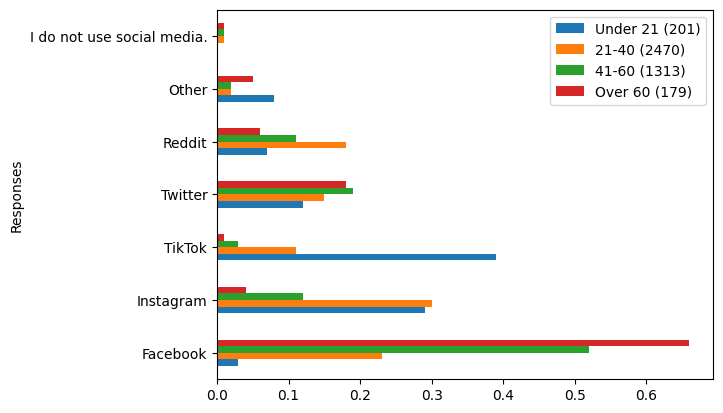

In [6]:
#choose question and segments
qid = 4
segs = [10,21,22,23]

#plot
d =plot_poll(qs[qid],segs)

#Visusalize collective response question data

Here we create a simple visualization of the results of a **collective response** question (aka "ask opinion" on Remesh) where users respond with natural language and then vote on the responses submitted by others. The visualization is generated for a selected *question* and *set of segments*. In the visualization each row corresponds to a response, columns correspond to the selected set of segments, and values correspond to the fraction of each segment which  agrees* with each response.

**this agreement fraction is computed on Remesh using [elicitation inference](https://openreview.net/pdf?id=tkxnRPkb_H). We sample around 10-30 votes per person, then infer the rest. Accuracy of individual vote inferences is 75-80%, and the aggregated agreement fraction values for each segment have a 1 stdv confidence range of around +/- 1-3%.*

In [9]:
#plot ask opinion data
def make_pretty(styler):
  styler.background_gradient(axis=None, vmin=0, vmax=1, cmap="RdYlGn")
  styler.format(precision=2)
  return styler

#generate the table of data
def table_ask(df,segs,n):
  print(df["Question"][1])
  segs_incl = ['Responses']
  for i in range(0,len(segs)):
    segs_incl.append(df.columns[5+segs[i]])
  dfplt = df[segs_incl]
  #dfplt = dfplt.set_index('Responses')
  return dfplt.iloc[:n].style.pipe(make_pretty)



In [10]:
#choose question and segments
qid = 11
segs = [0,10,21,22,23,8,9]

#plot
table_ask(qs[qid],segs,30)

How would you change social media platforms to make them more trustworthy?


,Responses,All(4018),Under 21 (193),21-40 (2385),41-60 (1270),Over 60 (170),Male (1976),Female (1980)
0,Increase independent fact checking and make a larger financial contribution to that and increase awareness about misinformation and its causes as well as effects,0.82,0.86,0.82,0.82,0.73,0.80,0.83
1,I would like them to employ more fact checkers or alter their algorithms to try and counter the spread of misinformation.,0.82,0.85,0.82,0.81,0.73,0.80,0.84
2,They need to invest in better management systems that allow false information to be spotted quicker and taken down,0.82,0.85,0.82,0.81,0.74,0.80,0.83
3,"Have more monitoring of posts, to ensure that fake news/misinformation etc is removed.",0.82,0.84,0.82,0.82,0.75,0.80,0.83
4,Independent fact checkers. The platform is financially responsible and legally responsible for content.,0.82,0.85,0.82,0.82,0.73,0.80,0.84
5,They need to be more responsive to complaints. They need to fact check. They need to listen,0.82,0.84,0.82,0.82,0.73,0.80,0.84
6,I would ensure they have more people checking them or more algorithms to pick up false info,0.81,0.84,0.82,0.81,0.73,0.79,0.84
7,"Have more fact checking on articles, and also have dedicated teams working to stop the spread of misinformation.",0.81,0.84,0.82,0.82,0.75,0.80,0.83
8,Use more artificial intelligence to monitor and block fake news post,0.81,0.85,0.82,0.81,0.74,0.80,0.83
9,"Promote more fact checking, and change algorithms so that people can see a wide range of views.",0.81,0.84,0.82,0.81,0.73,0.80,0.83


#Generate bridging and polarization metrics across a specified set of segments

Here we compute simple versions of both bridging and polarization metrics for each response.

**The bridging metric** is meant to capture the degree to which there is agreement for a response across ALL specified population segments; even those which typically disagree. To capture this we use the segment-level analouge of a Max-Min social wellfare function. If a_ij is the fraction of the j^th segment which agrees with i^th response, then we compute the bridging metric for that response as b_i = MIN(a_i1,a_i2,...,a_iN)

**The polarization metric** is meant to capture the degree to which there is polariation between specified segments about a response. To capture this we compute the difference in agreement fraction for the segments which most agree with the response and least agree with the response. ie p_i = MAX(a_i1,a_i2,...,a_iN) - MIN(a_i1,a_i2,...,a_iN)

*We note that both of these are simplistic metrics and that more sophisticated versions might be prefered. This is a potential vector of improvement for this prototype*

In [11]:
#compute min-based bridging metric
def min_bridge(row,segs_incl,col):
  b = 1
  for s in range(0,len(segs_incl)):
    b_ = row[segs_incl[s]]
    b = min(b,b_)
  return b

#compute max-min polarization metric
def polarization(row,segs_incl,col):
  mx = 0
  mn = 1
  for s in range(0,len(segs_incl)):
    b_ = row[segs_incl[s]]
    mx = max(mx,b_)
    mn = min(mn,b_)
  return mx-mn

#generate dataframe which includes bridging and polarization metrics
def bridging_ask(df,segs,n):
  print(df["Question"][1])
  segs_incl = ['Responses']
  for i in range(0,len(segs)):
    segs_incl.append(df.columns[5+segs[i]])
  dfplt = df[segs_incl]
  dfplt["bridge"] = df.apply (lambda row: min_bridge(row,segs_incl[1:],df.columns), axis=1)
  dfplt["polarization"] = df.apply (lambda row: polarization(row,segs_incl[1:],df.columns), axis=1)
  return dfplt.sort_values(by=["bridge"],ascending=False).iloc[:n]

In [12]:
#choose question and segments
qid = 11
segs = [0,10,21,22,23,8,9]

#get table
ba = bridging_ask(qs[qid],segs,30)
ba.style.pipe(make_pretty)

How would you change social media platforms to make them more trustworthy?


,Responses,All(4018),Under 21 (193),21-40 (2385),41-60 (1270),Over 60 (170),Male (1976),Female (1980),bridge,polarization
625,Have them monitored more frequently by someone impartial,0.79,0.83,0.79,0.79,0.78,0.78,0.81,0.78,0.05
545,"remove political figures, fact check posts, fairer algorithims",0.80,0.81,0.80,0.80,0.78,0.78,0.81,0.78,0.03
483,Fact check more posts. Remove ads.,0.80,0.78,0.80,0.80,0.78,0.78,0.81,0.78,0.03
831,Add more fact checking.,0.78,0.81,0.79,0.78,0.78,0.77,0.80,0.77,0.04
67,Have more fact checking on them to avoid misinformation spreading.,0.81,0.84,0.81,0.81,0.77,0.80,0.83,0.77,0.07
706,provide more insight into data protection to third parties,0.79,0.81,0.79,0.79,0.78,0.77,0.81,0.77,0.04
646,to be monitorited more closely to review content quicker,0.79,0.83,0.79,0.79,0.77,0.78,0.81,0.77,0.06
794,Have more flagging of untrustworthy content,0.79,0.81,0.79,0.78,0.78,0.77,0.80,0.77,0.04
343,Penalize false information and harassing language,0.80,0.81,0.81,0.80,0.77,0.79,0.82,0.77,0.05
103,Fact check information that is fast trending and being shared at a high rate,0.81,0.84,0.81,0.81,0.77,0.79,0.83,0.77,0.07


#Select bridging responses

Here we select a set of responses whose bridging agreement is above a specified threshold. For now, we select the threshold such that the number of responses above it is small enough to fit within 8k the context window of the GPT-4 version we have access to so they can be used in the next step.

To highlight what this selection of responses equates to, we plot all responses as a function of their **overall agreement** (x-axis) and **polarization** (y-axis) and highlight those above the specific bridging threshold. This highlights the fact that selecting the responses with the highest bridging agreement generally equates to selecting responses with high overall agreement and low polarization; where the degree of polarization permissible is lower for responses with lower overall agreement.

In [ ]:
#plot agreement vs polairation and highlight bridging response over threshold
def plot_agreement_polarization_with_bridging(df,segs,thresh):
  bdf = bridging_ask(df,segs)
  bridge_true = bdf.loc[bdf['bridge']>thresh]
  bridge_false = bdf.loc[bdf['bridge']<=thresh]
  plt.figure(figsize=(8,8))
  plts=plt.scatter(bdf[bdf.columns[2]],bdf["polarization"],c=bdf["bridge"],cmap="RdYlGn",alpha=0.15,edgecolors='none',s=80, label='all')
  plt.legend(*plts.legend_elements(),bbox_to_anchor=(1.0, 1.0),loc="upper left", title="Bridging Agreement",frameon=False)
  plt.scatter(bridge_true[bridge_true.columns[2]],bridge_true["polarization"],edgecolors="black",s=90,facecolors='none', label='bridge>thresh')
  plt.xlabel("Overall Agreement")
  plt.ylabel("Polarization")

  return plt.show()


In [ ]:
def get_bridging_responses(df,segs,thresh):
  bdf = bridging_ask(df,segs)
  return bdf.loc[bdf['bridge']>thresh]

How would you change social media platforms to make them more trustworthy?


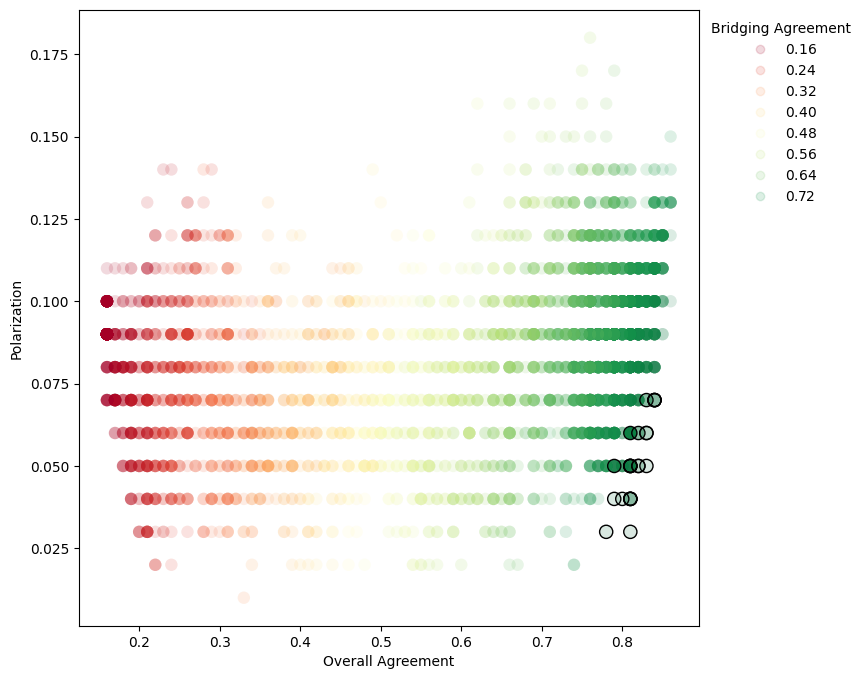

How would you change social media platforms to make them more trustworthy?


,Responses,All(4018),Under 21 (193),21-40 (2385),41-60 (1270),Over 60 (170),Male (1976),Female (1980),bridge,polarization
625,Have them monitored more frequently by someone impartial,0.79,0.83,0.79,0.79,0.78,0.78,0.81,0.78,0.05
545,"remove political figures, fact check posts, fairer algorithims",0.80,0.81,0.80,0.80,0.78,0.78,0.81,0.78,0.03
483,Fact check more posts. Remove ads.,0.80,0.78,0.80,0.80,0.78,0.78,0.81,0.78,0.03
831,Add more fact checking.,0.78,0.81,0.79,0.78,0.78,0.77,0.80,0.77,0.04
67,Have more fact checking on them to avoid misinformation spreading.,0.81,0.84,0.81,0.81,0.77,0.80,0.83,0.77,0.07
706,provide more insight into data protection to third parties,0.79,0.81,0.79,0.79,0.78,0.77,0.81,0.77,0.04
646,to be monitorited more closely to review content quicker,0.79,0.83,0.79,0.79,0.77,0.78,0.81,0.77,0.06
794,Have more flagging of untrustworthy content,0.79,0.81,0.79,0.78,0.78,0.77,0.80,0.77,0.04
343,Penalize false information and harassing language,0.80,0.81,0.81,0.80,0.77,0.79,0.82,0.77,0.05
103,Fact check information that is fast trending and being shared at a high rate,0.81,0.84,0.81,0.81,0.77,0.79,0.83,0.77,0.07


In [ ]:
#choose question and segments
qid = 11
segs = [0,10,21,22,23,8,9]
thresh = .76

#plot
plot_agreement_polarization_with_bridging(df,segs,thresh)

#table
ba = get_bridging_responses(qs[qid],segs,thresh)
ba.style.pipe(make_pretty)

# Distill unique ideas from bridging responses and generate policies based on those ideas

Here we use an LLM (GPT-4) to do two tasks:

1.   Generate a summary of the unique ideas found within the bridging responses.
2.   Genereate policies based on the unique ideas generated in step 1.


Here we note that the size of the context window of LLM we use limits the number of bridging responses which can be (easily) included in the summary tasks. Right now we use this limit to manually determine the briging agreement threshold we use in the previous section. If needed, it is likely possible to escape this limit by taking an iterative, hierarchical approch to summarization, ie by chunking briding responses into sets that fit in the context window limit, generating summaries for each chunk, then generating a summary of the summaries. This is vector for improvement of this prototype.

In [ ]:
!pip install langchain
!pip install openai
!pip install -U sentence-transformers
import os
os.environ["OPENAI_API_KEY"] = "your-key-here"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.7 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125925 sha256=dc6905166c2867a3f3b2f1c5d2c3dc3a9a480b56f36023

In [ ]:
#build the lang chain to do summary -> policies

#from langchain.llms import ChatOpenAI
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.chains import SequentialChain

#load LLM
llm = ChatOpenAI(temperature=0.5,model_name='gpt-4',max_tokens=7500)

#summarization prompt
summaryPrompt = PromptTemplate(
    input_variables=["question","responses"],
    template="""
    Participants in a research study were asked '{question}'.

    These are their responses:
    {responses}

    Summarize all of the unique ideas within these responses into very short bullet points.
    """
)
#add to chain
summaryChain = LLMChain(llm=llm, prompt=summaryPrompt,output_key="summary")

#policy prompt
policyPrompt = PromptTemplate(
    input_variables=["question","summary"],
    template="""
    Participants in a research study were asked '{question}'.

    The ideas they responded with were:
    {summary}

    A policy is a course or principle of action.

    Write a few clear and actionable policies in the form of bullet points based on these ideas. Avoid redundant policies.

    for example:

    - Enforce limits on the number of bad tacos any one person can eat.

    """
)
#add to chain
policyChain = LLMChain(llm=llm, prompt=policyPrompt,output_key="policies")

#build the chain
mainChain = SequentialChain(
    chains=[summaryChain, policyChain],
    input_variables=["question", "responses"],
    # Here we return multiple variables
    output_variables=["summary","policies"],
    verbose=False)

In [ ]:
#prepare data to be used in prompts

#choose question and segments
qid = 11
segs = [0,10,21,22,23,8,9]
thresh = .76

#build string of responses
ba = get_bridging_responses(qs[qid],segs,thresh)
responses_str = ''
for ind in ba.index:
  rsp = ba["Responses"][ind]
  responses_str+=rsp
  responses_str+="\n "

#get quesiton text
df = qs[qid]
question_str = df["Question"][1]

How would you change social media platforms to make them more trustworthy?


In [ ]:
#run the langchain on the data
out = mainChain({
    "question":question_str,
    "responses":responses_str
})

In [ ]:
print(out["summary"])

- Implement stricter fact-checking and moderation policies
- Enhance transparency about data usage and privacy
- Require user verification to reduce fake profiles
- Improve security measures to prevent data breaches
- Limit the amount of sponsored content and clearly label it
- Provide clearer guidelines for user behavior and content
- Increase user control over what they see and who can see their content
- Implement stricter penalties for those who spread misinformation
- Encourage more diverse viewpoints and reduce echo chambers
- Improve responsiveness to user reports and complaints
- Develop clearer policies on hate speech and harassment
- Provide education on digital literacy and critical thinking.


In [ ]:
print(out["policies"])

- Implement a comprehensive fact-checking system to verify the authenticity of information before it's posted.
- Enhance transparency by clearly stating how user data is collected, stored, and used.
- Require all users to undergo a verification process to authenticate their identity and minimize the creation of fake profiles.
- Strengthen security protocols and regularly update them to prevent any potential data breaches.
- Limit the volume of sponsored content and ensure it is clearly labeled as such to avoid confusion.
- Establish detailed guidelines for user behavior and content, ensuring they are easy to understand and follow.
- Develop a customizable user interface that allows users to control what they see and who can view their content.
- Enforce stricter penalties, including account suspension or deletion, for users who deliberately spread misinformation.
- Promote diversity by developing algorithms that show a variety of viewpoints, reducing the chance of users being stuck in 

# Estimate how well each policy is justified by the bridging responses

Here we aim to estimate the degree to which the bridging responses serve as evidece to support each policy. Our simple approach to this is to identify the bridging response which best supports each policy, then use how well that response supports the policy as a proxy for the overall strenght of evidence.

As a proxy for how well each response justifies each policy we use *semantic similarity*; ie. the cosine similarity between their corresponding embeddings. We note that a better way to quantify this might be to compute the degree of *entailment* between them, and we suspect GPT-4 may be used to compute entailment. This reprsents a potential vector of improvement for this prototype.


In [ ]:
#get embeddings for policies and bridging_responses
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

How would you change social media platforms to make them more trustworthy?


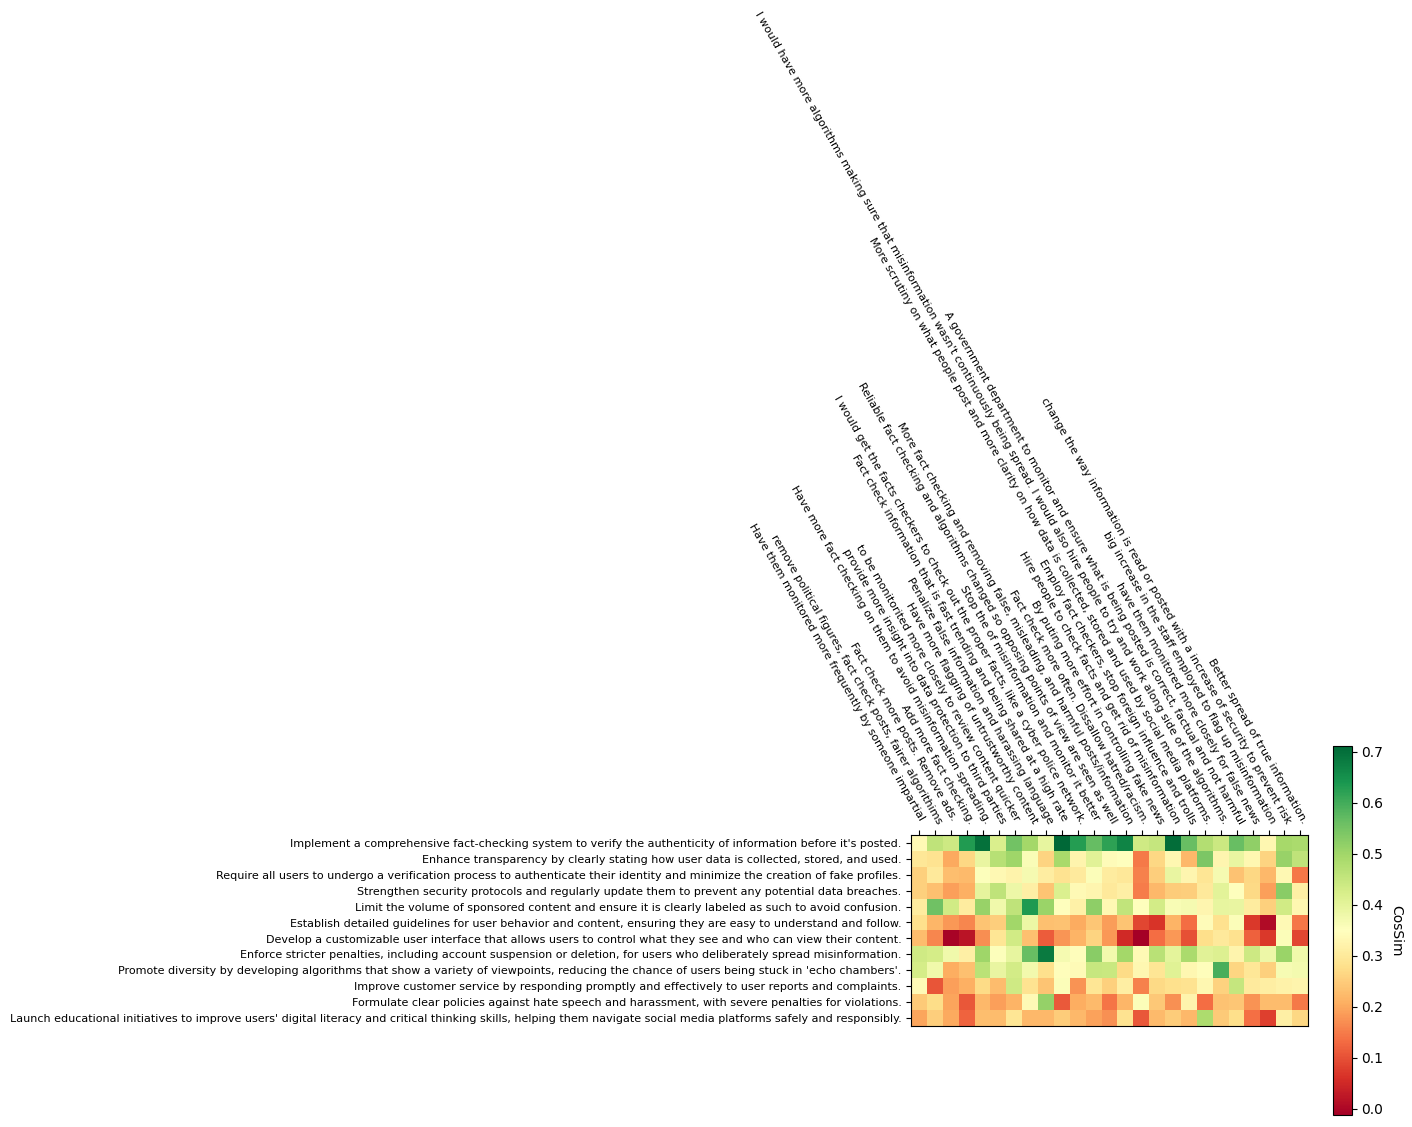

,Policy,Evidence strength,Evidence Response [briging support]
0,Implement a comprehensive fact-checking system to verify the authenticity of information before it's posted.,0.712007,Fact check information that is fast trending and being shared at a high rate [bridging support=77%]
7,"Enforce stricter penalties, including account suspension or deletion, for users who deliberately spread misinformation.",0.682581,Penalize false information and harassing language [bridging support=77%]
4,Limit the volume of sponsored content and ensure it is clearly labeled as such to avoid confusion.,0.634346,Have more flagging of untrustworthy content [bridging support=77%]
8,"Promote diversity by developing algorithms that show a variety of viewpoints, reducing the chance of users being stuck in 'echo chambers'.",0.593608,I would have more algorithms making sure that misinformation wasn't continuously being spread. I would also hire people to try and work along side of the algorithms. [bridging support=77%]
1,"Enhance transparency by clearly stating how user data is collected, stored, and used.",0.540765,"More scrutiny on what people post and more clarity on how data is collected, stored and used by social media platforms. [bridging support=77%]"
3,Strengthen security protocols and regularly update them to prevent any potential data breaches.,0.527519,change the way information is read or posted with a increase of security to prevent risk [bridging support=77%]
10,"Formulate clear policies against hate speech and harassment, with severe penalties for violations.",0.512698,Penalize false information and harassing language [bridging support=77%]
5,"Establish detailed guidelines for user behavior and content, ensuring they are easy to understand and follow.",0.497512,to be monitorited more closely to review content quicker [bridging support=77%]
11,"Launch educational initiatives to improve users' digital literacy and critical thinking skills, helping them navigate social media platforms safely and responsibly.",0.485373,"More scrutiny on what people post and more clarity on how data is collected, stored and used by social media platforms. [bridging support=77%]"
9,Improve customer service by responding promptly and effectively to user reports and complaints.,0.448869,"A government department to monitor and ensure what is being posted is correct, factual and not harmful [bridging support=77%]"


In [ ]:
import numpy as np

#extract policies
policies = list(map(lambda x: x[2:],out["policies"].splitlines()))

#extract bridging responses
import math
bridging_responses = []
bridging_responses_with_bridging_support = []
bridging_support = []
ba = get_bridging_responses(qs[qid],segs,thresh)
responses_str = ''
for ind in ba.index:
  rsp = ba["Responses"][ind]
  bridging_responses.append(rsp)
  bridging_support.append(ba["bridge"][ind])
  rsp += " [bridging support="
  b = math.floor(ba["bridge"][ind]*100)
  rsp +=str(b)
  rsp +="%]"
  bridging_responses_with_bridging_support.append(rsp)

#function to get embeddings
def get_embedding(text_list,model):
  embeddings = [model.encode(text) for text in text_list]
  return np.squeeze(embeddings)

#get embeddings for policies and bridging responses
ep = get_embedding(policies,model)
er = get_embedding(bridging_responses,model)

#compute similarity matrix between policies and responses
sim = cosine_similarity(ep,er)

#visualize simialrlity matrix between policies and bridging responses
fig, ax = plt.subplots()
im = ax.imshow(sim,cmap="RdYlGn")
xt = ax.set_xticks(np.arange(len(bridging_responses)), labels=bridging_responses,fontsize=8)
yt = ax.set_yticks(np.arange(len(policies)), labels=policies,fontsize=8)
cbar = ax.figure.colorbar(im, ax=ax)
ax.tick_params(top=True, bottom=False,labeltop=True, labelbottom=False)
cbar.ax.set_ylabel("CosSim", rotation=-90, va="bottom")
fig.tight_layout()
plt.setp(ax.get_xticklabels(), rotation=-60, ha="right",rotation_mode="anchor")
plt.show()

#compute best supporting response for each policy
supporting_response_index = [sim[j].argmax() for j in range(0,len(policies))]
supporting_responses = [bridging_responses_with_bridging_support[supporting_response_index[j]] for j in range(0,len(policies))]
evidence_strength = [sim[j].max() for j in range(0,len(policies))]
#evidence_strength = [sim[j].max()*bridging_support[j] for j in range(0,len(policies))]

#create data frame with policies and suppporting responses
pd.set_option('display.max_colwidth', 0)
psrdf = pd.DataFrame()
psrdf["Policy"] = policies
psrdf["Evidence strength"] = evidence_strength
psrdf["Evidence Response [briging support]"] = supporting_responses
psrdf=psrdf.sort_values(by=["Evidence strength"],ascending=False)
psrdf_formated = psrdf.style.set_properties(**{'text-align': 'left'})
psrdf_formated = psrdf_formated.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
psrdf_formated.background_gradient(axis=None, vmin=0, vmax=1, cmap="RdYlGn")